# Simulating fNIRS data

## Set up

We will be using functions from the NumPy, Matplotlib, and SciPy Python packages. Custom functions are located in the `src/HRF.py` script, and can be loaded as a package itself:

In [26]:
import sys
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, uniform
sys.path.append("../") 
from src.HRF import *

## Paradigm parameters

Here we set some parameters of the block design:

* `N_CHANNELS`: number of channels to simulate in each dataset. For each channel two time series will be simulated: one for deoxy-hemoglobin (HbO) and one for oxy-hemoglobin (HbR). Set at 5, for simplicity.
* `N_BLOCKS`: number of blocks in the block design. Following Gervain et al. (2012) we set it to 28. Note that in the original task, 14 of the blocks belonged to one experimental condition, and the other 14 belonged to a different experimental condition. For now, we will treat all blocks as belonging to the same condition.
* `N_STIM`: number of stimulus in each block. Following Gervain et al. (2012), in which 10 words were presented to participants in each block, we set this value at 10.
* `STIM_DURATION`: duration of each stimulus in seconds, set at 0.81 seconds. This is the result of `0.27 * 3`, where 0.27 is the duration of each syllable in each word (syllables were generated using a speech synthesizer), and 3 is the number of syllables in each word.
* `ISI`: inter-stimulus interval in seconds, or silent time elapsed between the offset of one stimulus (i.e., word) and the onset of the word following. This is set at 1.5 seconds, although note that in Gervain et al. some ISIs were 1.5 or 0.5 seconds.
* `IBI`: inter-block interval in seconds, or silent time elapsed between the offset of one block, and the onset of the next block. This is set at 18 seconds, although note that in Gervain et al. some ISIs were 18 or 25 seconds.

In [27]:
N_CHANNELS = 5
N_BLOCKS = 28
N_STIM = 10
STIM_DURATION = 0.27 * 3
ISI = 1.5
IBI = 18

## fNIRS parameters

Here we set some parameters related to the simulated NIRS signal. These parameters are the default in the `HRF` function, and have been manually set so that the resulting simulated signal is plausible for the population in Gervain et al. (2012): newborns.

* `AMPLITUDE`: mean amplitude of the HbO concentration signal (the HbR signal will result from a transformation of the HbO signal), in μM x mm.
* `PEAK_DELAY`: time elapsed from the presentation of a stimulus (i.e., trigger) until the peak of the HbO signal, in seconds.
* `PEAK_WIDTH`: time elapsed from the presentation of a stimulus (i.e., trigger) until the signal decays back to baseline, in seconds.
* `RATIO`: scaling of the amplitude of the HbO signal that results in the amplitude of the HbR signal. Values lower than 1 attenuate the signal, values larger than 1 amplity the signal.

Let's set these parameters and visualise the resulting HRF:

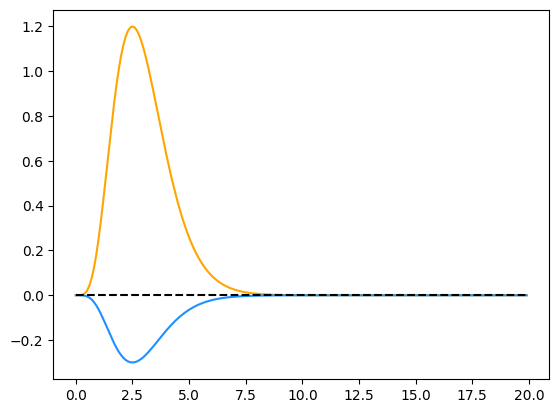

In [28]:
AMPLITUDE = 1.2
PEAK_DELAY = 5.0
PEAK_WIDTH = 0.5
RATIO = 0.80

sfreq = 10
time = np.arange(0, 20, 1/sfreq)
hbo, hbr = hrf(time, ratio=0.25)

plt.plot(time, hbo, color = "orange")
plt.plot(time, hbr, color = "dodgerblue")

plt.hlines(y=[0], 
           xmin=np.min(time), 
           xmax=np.max(time),
           color="black", linestyles="dashed")

When simulating the HRF of a block design, multiple HRF signals are generated, each evoked by a stimulus presentation. Not all signals must be identical. To reflect this uncertainty, the custom functions used to carry out the simulation draw the relevant parameters from probabilistic distributions. Particularly, from a normal distribution. To get a better idea of twhat this uncertainty looks like, lets draw 100 sets of parametes and generate 100 HRF with them. First, we genre

(array([ 3.,  3.,  7., 15., 17., 25., 17.,  8.,  3.,  2.]),
 array([-0.31053457, -0.23127122, -0.15200786, -0.07274451,  0.00651884,
         0.08578219,  0.16504554,  0.24430889,  0.32357224,  0.40283559,
         0.48209894]),
 <BarContainer object of 10 artists>)

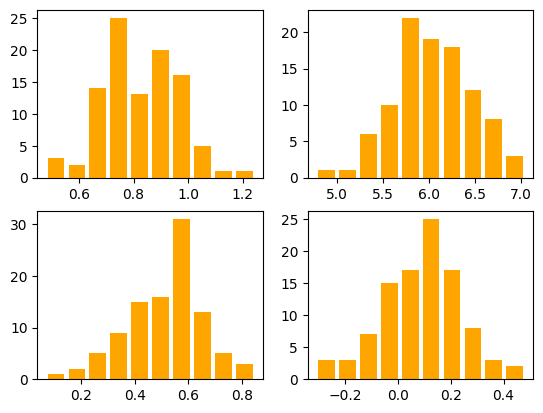

In [29]:
n_iter = 100

adist = norm(0.80, 0.15)
ddist = norm(6, 0.5)
wdist = norm(0.5, 0.15)
rdist = norm(0.1, 0.15)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.hist(adist.rvs(n_iter), rwidth=0.8, color="orange")
ax2.hist(ddist.rvs(n_iter), rwidth=0.8, color="orange")
ax3.hist(wdist.rvs(n_iter), rwidth=0.8, color="orange")
ax4.hist(rdist.rvs(n_iter), rwidth=0.8, color="orange")

Now we generate the HRF for each of the 100 sets of parameters:

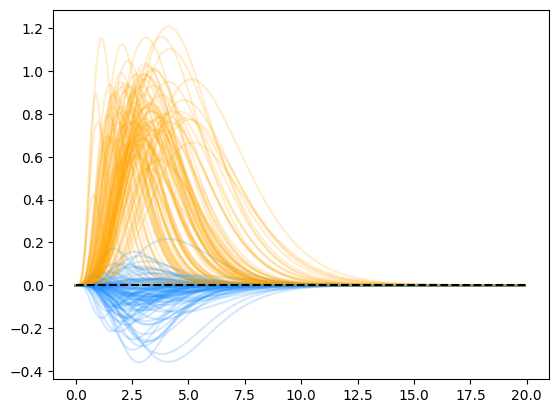

In [31]:
for (a, d, w, r) in zip(adist.rvs(n_iter), 
                        ddist.rvs(n_iter), 
                        wdist.rvs(n_iter),
                        rdist.rvs(n_iter)):
    hbo, hbr = hrf(time, a, d, w, r)
    plt.plot(time, hbr, c="dodgerblue", alpha=1/5)
    plt.plot(time, hbo, c="orange", alpha=1/5)
plt.hlines(y=[0], xmin=0, xmax=20,
           color="black", linestyles="dashed")
plt.show()

As you can see, the HbO signal has a consistently larger peak (in absolute terms) compared to the HbR, and is consistently positive. On the contrary, the HbR signal has a smaller peak, and although it is negative most of the times, it is sometimes positive. This is a somewhat plausible outome of the simulations. The canonical HRF in fNIRS involves an increase in HbO concentration, and most of the times, a decrease in HbR. But this is not always the case, mainly due to the inconsistency of the HbR change in concentration. 

## Simulate a block

Block duration is 15.600000000000001 seconds
Run duration is 8299.199999999997 seconds


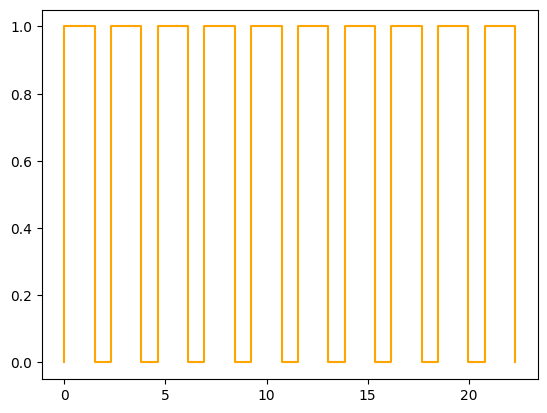

In [32]:
block_duration = np.sum(
    [STIM_DURATION] * N_STIM +
    [ISI] * int(N_STIM / 2))
print(f"Block duration is {block_duration} seconds")

run_duration = np.sum(np.repeat(block_duration, N_BLOCKS + IBI * N_BLOCKS))
print(f"Run duration is {run_duration} seconds")

onsets, offsets = sim_block(N_STIM, STIM_DURATION, ISI)

boxcar = np.hstack([[x, x, y, y] for (x, y) in zip(onsets, offsets)])
plt.plot(boxcar, 
         np.hstack([[0, 1, 1, 0]
                   for _ in np.arange(len(onsets))]),
         color = "orange")
plt.show()

## Simulating a block design

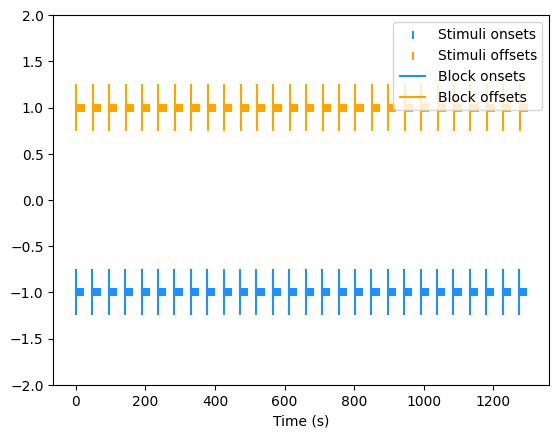

In [33]:
blocks_labels = ["A", "B"]
blocks = blocks_labels * int(N_BLOCKS / len(blocks_labels))

_, onset_design, offset_design = sim_design(blocks=blocks)
block_onsets = np.min(onset_design, axis=1)
block_offsets = np.min(offset_design, axis=1)
y_onsets = np.vstack([np.repeat(-1, len(x)) for x in onset_design])
y_offsets = np.vstack([np.repeat(1, len(x)) for x in offset_design])

plt.scatter(onset_design, y_onsets, marker="|",
            label="Stimuli onsets", color="dodgerblue")
plt.scatter(offset_design, y_offsets, marker="|",
            label="Stimuli offsets", color="orange")
plt.vlines(block_onsets, ymin=-1.25, ymax=-0.75,
           label="Block onsets", colors="dodgerblue")
plt.vlines(block_offsets, ymin=0.75, ymax=1.25,
           label="Block offsets", colors="orange")
plt.legend(loc="upper right")
plt.xlabel(xlabel="Time (s)")
plt.ylim([-2, 2])
plt.show()

## Simulating a NIRS signal

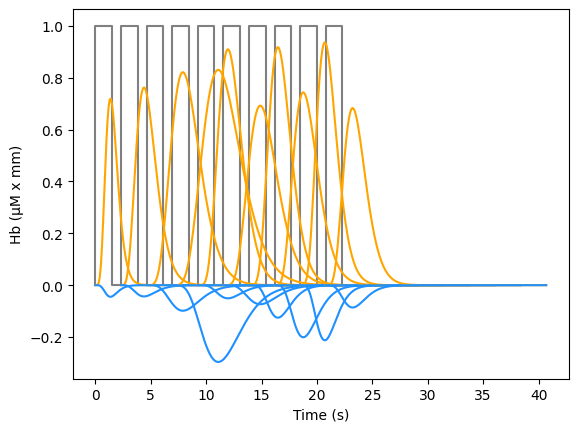

In [34]:
# add signal
hrf_list = []
time_list = []
time = np.arange(0, 20, 0.1)
amplitudes = {
    "A": 0.80,
    "B": 2.00
}
for o in onsets:
    hrf_list.append(hrf(time,
                        adist.rvs(1), 
                        ddist.rvs(1),
                        wdist.rvs(1),
                        rdist.rvs(1)))
    time_list.append(o + time)

onsets, offsets = sim_block(N_STIM, STIM_DURATION, ISI)
boxcar = np.hstack([[x, x, y, y]
                    for (x, y) in zip(onsets, offsets)])

plt.plot(boxcar,
        np.hstack([[0, 1, 1, 0] for _ in np.arange(len(onsets))]),
        color="grey")

hbo_list = []
hbr_list = []
for t, (hbo, hbr) in zip(time_list, hrf_list):
    hbo_list.append(hbo)
    hbr_list.append(hbr)
    plt.plot(t, hbo, color="orange", label = "HbO")
    plt.plot(t, hbr, color="dodgerblue", label = "HbR")
    plt.xlabel(xlabel="Time (s)")
    plt.ylabel(ylabel="Hb (μM x mm)")


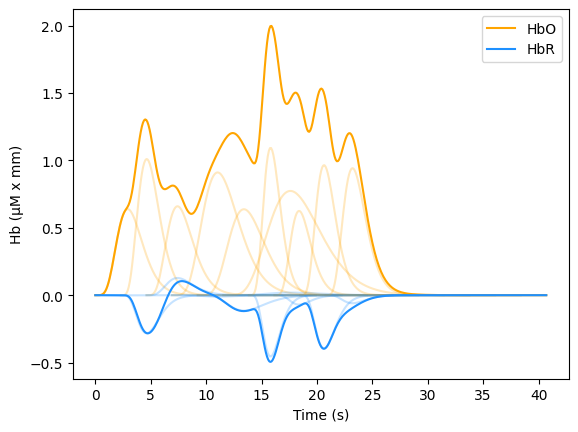

In [9]:
hbo_conv, times_conv = convolve_responses(time_list, hbo_list)
hbr_conv, _ = convolve_responses(time_list, hbr_list)

for t, (hbo, hbr) in zip(time_list, hrf_list):
    hbo_list.append(hbo)
    hbr_list.append(hbr)
    plt.plot(t, hbo, color="orange", alpha=1/4)
    plt.plot(t, hbr, color="dodgerblue", alpha=1/4)
plt.plot(times_conv, hbo_conv, color="orange", label = "HbO")
plt.plot(times_conv, hbr_conv, color="dodgerblue", label = "HbR")
plt.xlabel(xlabel="Time (s)")
plt.ylabel(ylabel="Hb (μM x mm)")
plt.legend(loc="upper right")
plt.show()

## Adding noise and phisiological arctifacts

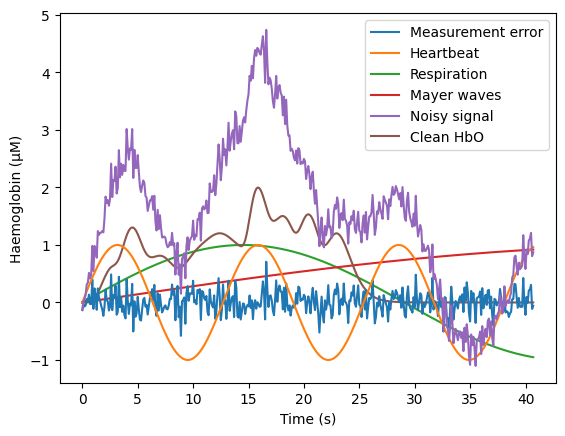

In [35]:
heart_noise = generate_noise(hbo_conv, times_conv, type="heart")
resp_noise = generate_noise(hbo_conv, times_conv, type="respiration")
mayer_noise = generate_noise(hbo_conv, times_conv, type="mayer")
white_noise = generate_noise(hbo_conv, times_conv, type="white")

hbo_noise = np.sum([hbo_conv, white_noise, heart_noise,
                    resp_noise, mayer_noise], 0)

plt.plot(times_conv, white_noise, label="Measurement error")
plt.plot(times_conv, heart_noise, label="Heartbeat")
plt.plot(times_conv, resp_noise, label="Respiration", zorder=0)
plt.plot(times_conv, mayer_noise, label="Mayer waves", zorder=0)
plt.plot(times_conv, hbo_noise, label="Noisy signal")
plt.plot(times_conv, hbo_conv, label="Clean HbO", zorder=0)
plt.legend(loc="upper right")
plt.xlabel(xlabel="Time (s)")
plt.ylabel(ylabel="Haemoglobin (μM)")
plt.show()

## Simulating a channel

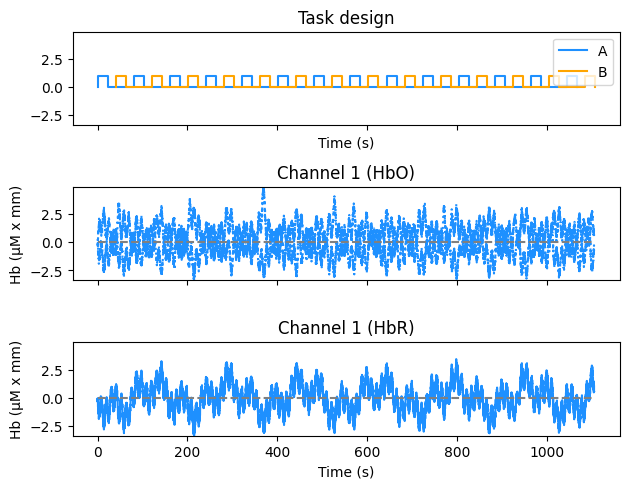

In [49]:
amplitudes = {
    "A": 0.80,
    "B": 2.00
}
hbo, hbr, times = sim_channel(onset_design, blocks, amplitudes)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)

blocks, onset_design, offset_design = sim_design(blocks, ibi=IBI)
block_onsets = np.min(onset_design, axis=1)
block_offsets = np.max(offset_design, axis=1)

boxcar_onsets_a = np.hstack([[x, x, y, y]
                    for (x, y) in zip(
                        block_onsets[[b=="A" for b in blocks]], 
                        block_offsets[[b=="A" for b in blocks]])])
boxcar_onsets_b = np.hstack([[x, x, y, y]
                    for (x, y) in zip(
                        block_onsets[[b=="B" for b in blocks]], 
                        block_offsets[[b=="B" for b in blocks]])])

ax1.plot(boxcar_onsets_a,
        np.hstack([[0, 1, 1, 0] for _ in np.arange(
            len(block_onsets[[b=="A" for b in blocks]]))]),
        color="dodgerblue",
        label = "A")
ax1.plot(boxcar_onsets_b,
        np.hstack([[0, 1, 1, 0] for _ in np.arange(
            len(block_onsets[[b=="B" for b in blocks]]))]),
        color="orange",
        label = "B")

ax1.legend(loc="upper right")
ax1.set_xlabel(xlabel="Time (s)")
ax1.set_title("Task design")
ax1.set_ylim([0, 1.5])

hbo_a = [x for (x, b) in zip(hbo, blocks) if "A" in b]
hbr_a = [x for (x, b) in zip(hbr, blocks) if "A" in b]
hbo_b = [x for (x, b) in zip(hbo, blocks) if "B" in b]
hbr_b = [x for (x, b) in zip(hbr, blocks) if "B" in b]


ax2.plot(times, hbo, label="HbR", color="dodgerblue", ls = "dotted")
ax2.plot(times, hbr, label="HbR", color="dodgerblue", ls = "dotted")

ax2.hlines(y=[0], xmin=0, xmax=np.max(times),
           color="grey", linestyles="dashed")
ax2.set_ylabel(ylabel="Hb (μM x mm)")
ax2.set_title("Channel 1 (HbO)")
ax1.set_ylim([np.min(hbr), np.max(hbo)])


ax3.plot(times, hbr, label="HbR", color="dodgerblue")
ax3.hlines(y=[0], xmin=0, xmax=np.max(times),
           color="grey", linestyles="dashed")
ax3.set_ylabel(ylabel="Hb (μM x mm)")
ax3.set_title("Channel 1 (HbR)")
plt.tight_layout()
plt.xlabel(xlabel="Time (s)")
plt.title("Channel 1 (HbR)")
ax1.set_ylim([np.min(hbr), np.max(hbo)])

plt.show()

In [ ]:
#[ax2.plot(times, x, color="dodgerblue") for x in hbo_a]
len(hbo)

11055

## Simulating a dataset

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_21212\3639777211.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


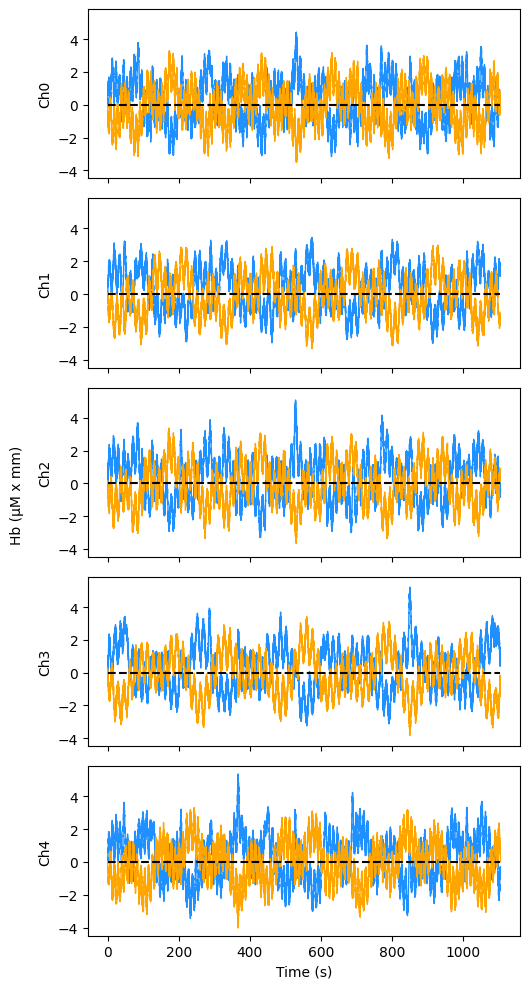

In [23]:
import re
dataset, times, ch_names = sim_dataset(onset_design,
                                       blocks = blocks,
                                       n_channels=N_CHANNELS,
                                       amplitude = amplitudes)

fig, ax = plt.subplots(nrows=N_CHANNELS,
                       ncols=1,
                       sharex=True,
                       sharey=True,
                       layout="constrained")
hbo_all = [d for (d, c) in zip(dataset, ch_names) 
           if "HbO" in c]
hbr_all = [d for (d, c) in zip(dataset, ch_names) 
           if "HbR" in c]
ch_names_unique = [x for x  in ch_names if "HbO" in x]
ch_names_unique = [re.sub(" HbO| HbR", "", x) for x in ch_names]
ch_names_unique = np.unique([re.sub(" HbO| HbR", "", x) for x in ch_names])

ax1.plot(boxcar_onsets_a,
        np.hstack([[0, 1, 1, 0] for _ in np.arange(
            len(block_onsets[[b=="A" for b in blocks]]))]),
        color="dodgerblue",
        label = "A")
ax1.plot(boxcar_onsets_b,
        np.hstack([[0, 1, 1, 0] for _ in np.arange(
            len(block_onsets[[b=="B" for b in blocks]]))]),
        color="orange",
        label = "B")

times = times[np.arange(0, len(dataset), 2)]
for idx, (hbo, hbr, t, c) in enumerate(zip(hbo_all, 
                            hbr_all, 
                            times,
                            ch_names_unique)):
    ax[idx].plot(t, np.transpose(hbo), color="dodgerblue", lw = 1)
    ax[idx].plot(t, np.transpose(hbr), color="orange", lw = 1)
    ax[idx].hlines([0], xmin = 0, xmax = np.max(times),
                   color  ="black", linestyles="dashed")
    ax[idx].set_ylabel(c)
    

fig.text(-0.05, 0.5,
         "Hb (μM x mm)",
         va="center",
         rotation="vertical")
fig.set_size_inches(5, 10, forward=True)
plt.xlabel(xlabel="Time (s)")

plt.tight_layout()

In [81]:
N_CHANNELS

5

In [16]:
amplitudes

array([0.65733418])